In [576]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import random
from contextualized.easy import ContextualizedRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [577]:
# Set all random seeds
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If using GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Parameters
n_stocks = 100
n_quarters = 20
industries = ["Tech", "Energy", "Finance", "Healthcare", "Utilities"]

# Define IDs
stocks = [f"Stock_{i}" for i in range(n_stocks)]
quarters = list(range(n_quarters))
industry_map = {stock: np.random.choice(industries) for stock in stocks}

# Panel setup
index = pd.MultiIndex.from_product([stocks, quarters], names=["stock_id", "quarter"])
df = pd.DataFrame(index=index).reset_index()

# Assign industries
df["industry"] = df["stock_id"].map(industry_map)

# Simulate predictors
df["investment_spread"] = np.random.normal(0, 1, len(df))  # predictor 1
df["credit_growth"] = np.random.normal(0, 1, len(df))      # predictor 2

# Homogeneous predictor effects (slopes)
hom_slope_1 = 1
hom_slope_2 = 0.5

# Time context variable: uncertainty index (e.g., economic uncertainty)
uncertainty_index = {q: np.random.uniform(0.5, 1.5) for q in quarters}
df["uncertainty_index"] = df["quarter"].map(uncertainty_index)

# Simulate a smooth recession signal (e.g., from -1 to 2)
recession_index = np.sin(np.linspace(0, 3 * np.pi, n_quarters)) + np.random.normal(0, 0.2, n_quarters)
recession_index = {q: recession_index[q] for q in quarters}
df["recession_index"] = df["quarter"].map(recession_index)

# Stock context variable: industry bias
industry_bias = {
    "Tech": 2.0,
    "Energy": 1.0,
    "Finance": 1.5,
    "Healthcare": 1.2,
    "Utilities": 0.8
}
df["industry_bias"] = df["industry"].map(industry_bias) #+ np.random.normal(0, 0.1, len(df))

# Simulated volatility per stock
volatility_map = {stock: np.random.normal(0, 1) for stock in stocks}
df["volatility_score"] = df["stock_id"].map(volatility_map)


# Homogeneous context effects (biases)
df["stock_bias"] = 1.1 * df["volatility_score"] + df["industry_bias"]
df["time_bias"] = -1.0 * df["recession_index"] * df["uncertainty_index"] #+ np.random.normal(0, 0.1, len(df))

# Slope modulated by true (but hidden) context interaction
df["credit_slope"] = 0.5 + 0.8 * df["uncertainty_index"] #+ np.random.normal(0, 0.1, len(df))

# Return generation
df["return"] = (
    + df["stock_bias"]
    + df["time_bias"]
    + 1.0 * df["investment_spread"]  # homogeneous
    + df["credit_slope"] * df["credit_growth"]  # hetero, context-modulated
    #+ np.random.normal(0, 0.1, len(df))  # overall noise
)


# Convert to panel format
df = df.set_index(["stock_id", "quarter"])
df.head(30)



industry  investment_spread  credit_growth  \
stock_id quarter                                                 
Stock_0  0        Healthcare          -0.896335       0.382255   
         1        Healthcare          -0.111988      -0.803977   
         2        Healthcare           1.468941       2.241135   
         3        Healthcare          -1.123898      -0.410281   
         4        Healthcare           0.950005      -2.425214   
         5        Healthcare           1.726516      -0.030172   
         6        Healthcare           0.457885      -0.073033   
         7        Healthcare          -1.684287       1.111719   
         8        Healthcare           0.326845       0.288126   
         9        Healthcare          -0.081119      -0.833835   
         10       Healthcare           0.467795      -0.286392   
         11       Healthcare           0.736122       0.327420   
         12       Healthcare          -0.779702      -2.164714   
         13       Healthcare          -0.843896       1.338622   
         14       Healthcare          -0.150534      -0.831170   
         15       Healthcare          -0.965558       1.417044   
         16       Healthcare           0.150489       0.392465   
         17       Healthcare          -0.113421       0.629594   
         18       Healthcare           2.633528       1.149423   
         19       Healthcare          -1.025091       0.573132   
Stock_1  0         Utilities          -0.782048       0.672886   
         1         Utilities           0.423943      -0.164416   
         2         Utilities           0.872705       0.372169   
         3         Utilities           2.287226      -0.587498   
         4         Utilities           1.622920      -0.343411   
         5         Utilities           0.823733       1.964695   
         6         Utilities           0.293059      -0.808194   
         7         Utilities           0.896630       0.154317   
         8         Utilities          -0.610322       0.113469   
         9         Utilities          -0.316166      -0.310754   

                  uncertainty_index  recession_index  industry_bias  \
stock_id quarter                                                      
Stock_0  0                 1.243435        -0.322404            1.2   
         1                 1.032827         0.320124            1.2   
         2                 1.360668         0.628338            1.2   
         3                 1.194918         1.072505            1.2   
         4                 0.510551         0.668701            1.2   
         5                 0.894090         0.506370            1.2   
         6                 1.350952         0.227505            1.2   
         7                 0.845859        -0.296970            1.2   
         8                 0.535215        -0.738253            1.2   
         9                 1.246180        -0.944200            1.2   
         10                1.302038        -1.043500            1.2   
         11                0.660594        -1.056474            1.2   
         12                1.037340        -0.404067            1.2   
         13                0.691955         0.258345            1.2   
         14                1.219234         0.586826            1.2   
         15                0.771550         0.994071            1.2   
         16                0.816215         0.879228            1.2   
         17                1.344971         1.036034            1.2   
         18                0.976322        -0.035316            1.2   
         19                1.169754         0.028288            1.2   
Stock_1  0                 1.243435        -0.322404            0.8   
         1                 1.032827         0.320124            0.8   
         2                 1.360668         0.628338            0.8   
         3                 1.194918         1.072505            0.8   
         4                 0.510551         0.668701         

In [578]:
df["credit_slope"].mean()

1.3081868325051136

In [579]:
# Run the fixed effects model
fixed_effects_model = PanelOLS(
    dependent=df["return"],
    exog=df[["investment_spread", "credit_growth"]],
    entity_effects=False,
    time_effects=False
)
results = fixed_effects_model.fit(cov_type="clustered", cluster_entity=True)

# Print summary
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 return   R-squared:                        0.5105
Estimator:                   PanelOLS   R-squared (Between):              0.1790
No. Observations:                2000   R-squared (Within):               0.8219
Date:                Thu, Apr 17 2025   R-squared (Overall):              0.5105
Time:                        19:42:09   Log-likelihood                   -3969.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1041.8
Entities:                         100   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                  F(2,1998)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):             1067.6
                            

In [580]:
# Predictions
df["predicted_return"] = results.predict().fitted_values
df_reset = df.reset_index()

df.head(25)

industry  investment_spread  credit_growth  \
stock_id quarter                                                 
Stock_0  0        Healthcare          -0.896335       0.382255   
         1        Healthcare          -0.111988      -0.803977   
         2        Healthcare           1.468941       2.241135   
         3        Healthcare          -1.123898      -0.410281   
         4        Healthcare           0.950005      -2.425214   
         5        Healthcare           1.726516      -0.030172   
         6        Healthcare           0.457885      -0.073033   
         7        Healthcare          -1.684287       1.111719   
         8        Healthcare           0.326845       0.288126   
         9        Healthcare          -0.081119      -0.833835   
         10       Healthcare           0.467795      -0.286392   
         11       Healthcare           0.736122       0.327420   
         12       Healthcare          -0.779702      -2.164714   
         13       Healthcare          -0.843896       1.338622   
         14       Healthcare          -0.150534      -0.831170   
         15       Healthcare          -0.965558       1.417044   
         16       Healthcare           0.150489       0.392465   
         17       Healthcare          -0.113421       0.629594   
         18       Healthcare           2.633528       1.149423   
         19       Healthcare          -1.025091       0.573132   
Stock_1  0         Utilities          -0.782048       0.672886   
         1         Utilities           0.423943      -0.164416   
         2         Utilities           0.872705       0.372169   
         3         Utilities           2.287226      -0.587498   
         4         Utilities           1.622920      -0.343411   

                  uncertainty_index  recession_index  industry_bias  \
stock_id quarter                                                      
Stock_0  0                 1.243435        -0.322404            1.2   
         1                 1.032827         0.320124            1.2   
         2                 1.360668         0.628338            1.2   
         3                 1.194918         1.072505            1.2   
         4                 0.510551         0.668701            1.2   
         5                 0.894090         0.506370            1.2   
         6                 1.350952         0.227505            1.2   
         7                 0.845859        -0.296970            1.2   
         8                 0.535215        -0.738253            1.2   
         9                 1.246180        -0.944200            1.2   
         10                1.302038        -1.043500            1.2   
         11                0.660594        -1.056474            1.2   
         12                1.037340        -0.404067            1.2   
         13                0.691955         0.258345            1.2   
         14                1.219234         0.586826            1.2   
         15                0.771550         0.994071            1.2   
         16                0.816215         0.879228            1.2   
         17                1.344971         1.036034            1.2   
         18                0.976322        -0.035316            1.2   
         19                1.169754         0.028288            1.2   
Stock_1  0                 1.243435        -0.322404            0.8   
         1                 1.032827         0.320124            0.8   
         2                 1.360668         0.628338            0.8   
         3                 1.194918         1.072505            0.8   
         4                 0.510551         0.668701            0.8   

                  volatility_score  stock_bias  time_bias  credit_slope  \
stock_id quarter                                                          
Stock_0  0                1.348880    2.683768   0.400888      1.494748   
         1                1.348880    2.683768  -0.330633      1.326262   
         2         

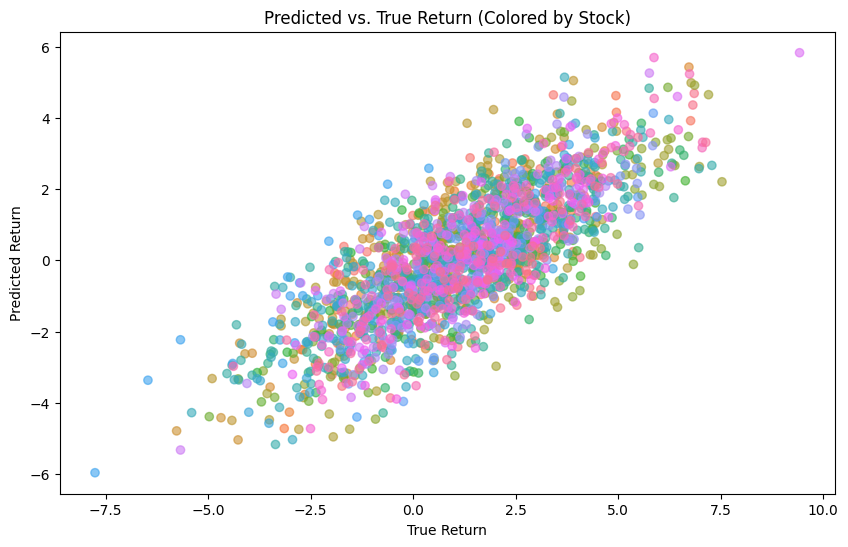

In [581]:
df = df.reset_index()

import seaborn as sns
# Create a color palette for stocks
unique_stocks = df["stock_id"].unique()
palette = sns.color_palette("husl", len(unique_stocks))  # bright, distinct colors
stock_color_map = dict(zip(unique_stocks, palette))

# Map stock_id to colors
colors = df["stock_id"].map(stock_color_map)

# Plot with colored points
plt.figure(figsize=(10, 6))
plt.scatter(df["return"], df["predicted_return"], c=colors, alpha=0.6)
plt.xlabel("True Return")
plt.ylabel("Predicted Return")
plt.title("Predicted vs. True Return (Colored by Stock)")
plt.show()

In [582]:
from sklearn.metrics import mean_squared_error, r2_score
print(f'Mean-squared Error: {mean_squared_error(df["return"], df["predicted_return"])}')
print(f'Correlation: {r2_score(df["return"], df["predicted_return"])}')

Mean-squared Error: 3.101263130020102
Correlation: 0.3748081816823362


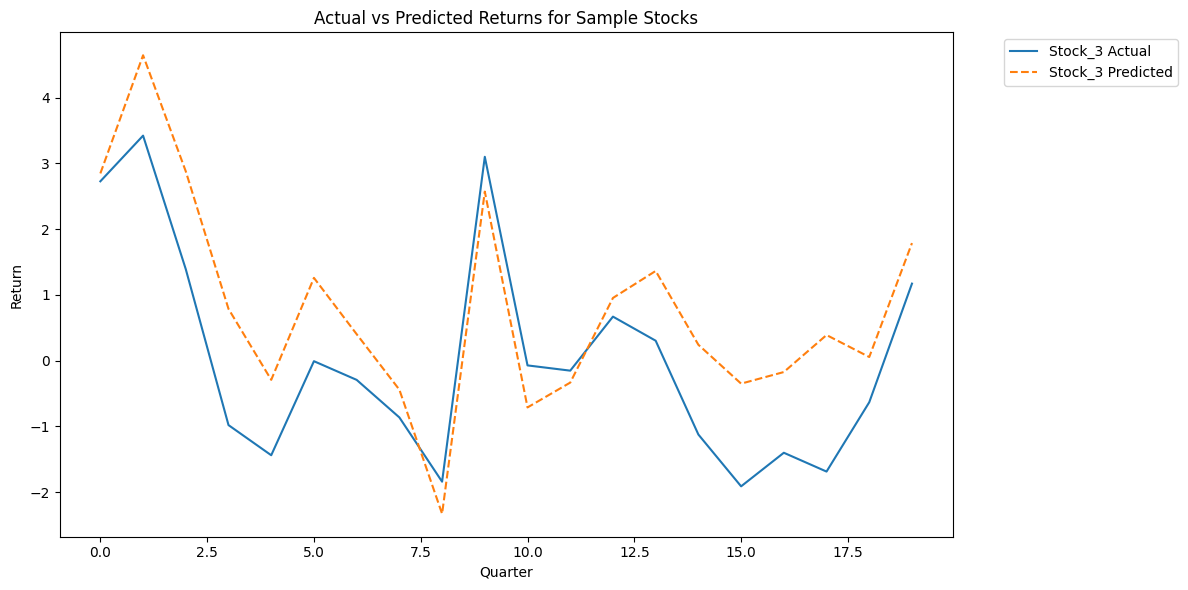

In [583]:
# Plot for first 5 stocks
fig, ax = plt.subplots(figsize=(12, 6))
sample_stocks = df_reset["stock_id"].unique()[3:4]

for stock in sample_stocks:
    stock_data = df_reset[df_reset["stock_id"] == stock]
    ax.plot(stock_data["quarter"], stock_data["return"], label=f"{stock} Actual", linestyle='-')
    ax.plot(stock_data["quarter"], stock_data["predicted_return"], label=f"{stock} Predicted", linestyle='--')

ax.set_title("Actual vs Predicted Returns for Sample Stocks")
ax.set_xlabel("Quarter")
ax.set_ylabel("Return")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [584]:
df = df.reset_index()

from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode stock_id and industry as integer categories
'''df["stock_code"] = df["stock_id"].astype("category").cat.codes
industry_encoder = LabelEncoder()
df["industry_code"] = industry_encoder.fit_transform(df["industry"])'''

# Average return per industry
avg_return_by_industry = df.groupby("industry")["return"].mean().to_dict()

# Map to each row
df["industry_avg_return"] = df["industry"].map(avg_return_by_industry)


C = df[["uncertainty_index", "recession_index", "industry_avg_return", "volatility_score"]].values
X = df[["investment_spread", "credit_growth"]].values
Y = df["return"].values.reshape(-1, 1)




In [585]:
C_train, C_test, X_train, X_test, Y_train, Y_test = train_test_split(C, X, Y, test_size=0.2, random_state=42)

def normalize(train, test):
    mean = train.mean(axis=0)
    std = train.std(axis=0)
    return (train - mean) / std, (test - mean) / std

In [586]:
model = ContextualizedRegressor(n_bootstraps=1)
model.fit(C, X, Y,
          encoder_type="mlp",
          max_epochs=10,
          learning_rate=1e-2)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/lightning_logs/boot_0_checkpoints exists and is not empty.

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | metamodel | NaiveMetamodel | 1.5 K  | train
-----------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


In [587]:
contextualized_coeffs, contextualized_offsets = model.predict_params(C)
Y_pred = model.predict(C, X)
df["predicted_return_context"] = Y_pred

print(f'Mean-squared Error: {mean_squared_error(Y, Y_pred)}')
print(f'Correlation: {r2_score(Y, Y_pred)}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Mean-squared Error: 0.11804396766100957
Correlation: 0.9762032050524717


In [588]:
contextualized_coeffs, contextualized_offsets

(array([[[1.20535898, 1.39523506]],
 
        [[1.08495092, 1.26358116]],
 
        [[1.06529903, 1.35912919]],
 
        ...,
 
        [[0.99684161, 1.34231365]],
 
        [[1.05717039, 1.25873852]],
 
        [[1.05602252, 1.28316212]]]),
 array([[2.8430686 ],
        [2.1398468 ],
        [1.66830349],
        ...,
        [0.99614614],
        [1.9025588 ],
        [1.81460619]]))

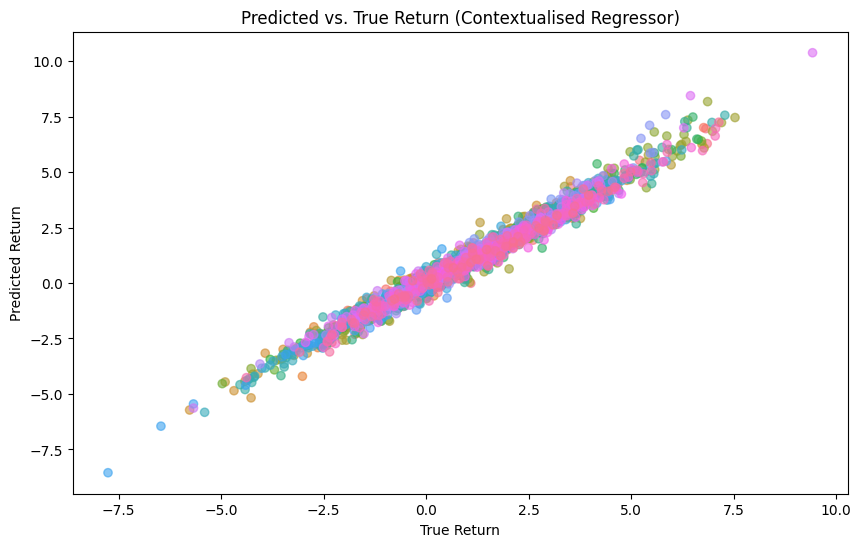

In [589]:
# Plot with colored points
plt.figure(figsize=(10, 6))
plt.scatter(df["return"], df["predicted_return_context"], c=colors, alpha=0.6)
plt.xlabel("True Return")
plt.ylabel("Predicted Return")
plt.title("Predicted vs. True Return (Contextualised Regressor)")
plt.show()

In [590]:
%%capture
coefs, offsets = model.predict_params(C, individual_preds=False)
coefs.shape # (n_samples, n_outputs, n_predictors)
offsets.shape  # (n_samples, n_outputs)

# Contextualized linear regression coefficients are shape:
# (n_samples, n_outputs, n_predictors)
# Let's squeeze out the n_outputs axis since we only have 1 output in this example.
coefs = np.squeeze(coefs)


from sklearn.decomposition import PCA
pca = PCA(n_components=2)
model_reps = pca.fit_transform(coefs)

C = pd.DataFrame(C, columns=["uncertainty_index", "recession_index", "industry_avg_return", "volatility_score"])
X = pd.DataFrame(X, columns=["investment_spread", "credit_growth"])

ValueError: Shape of passed values is (2000, 4), indices imply (2000, 2)

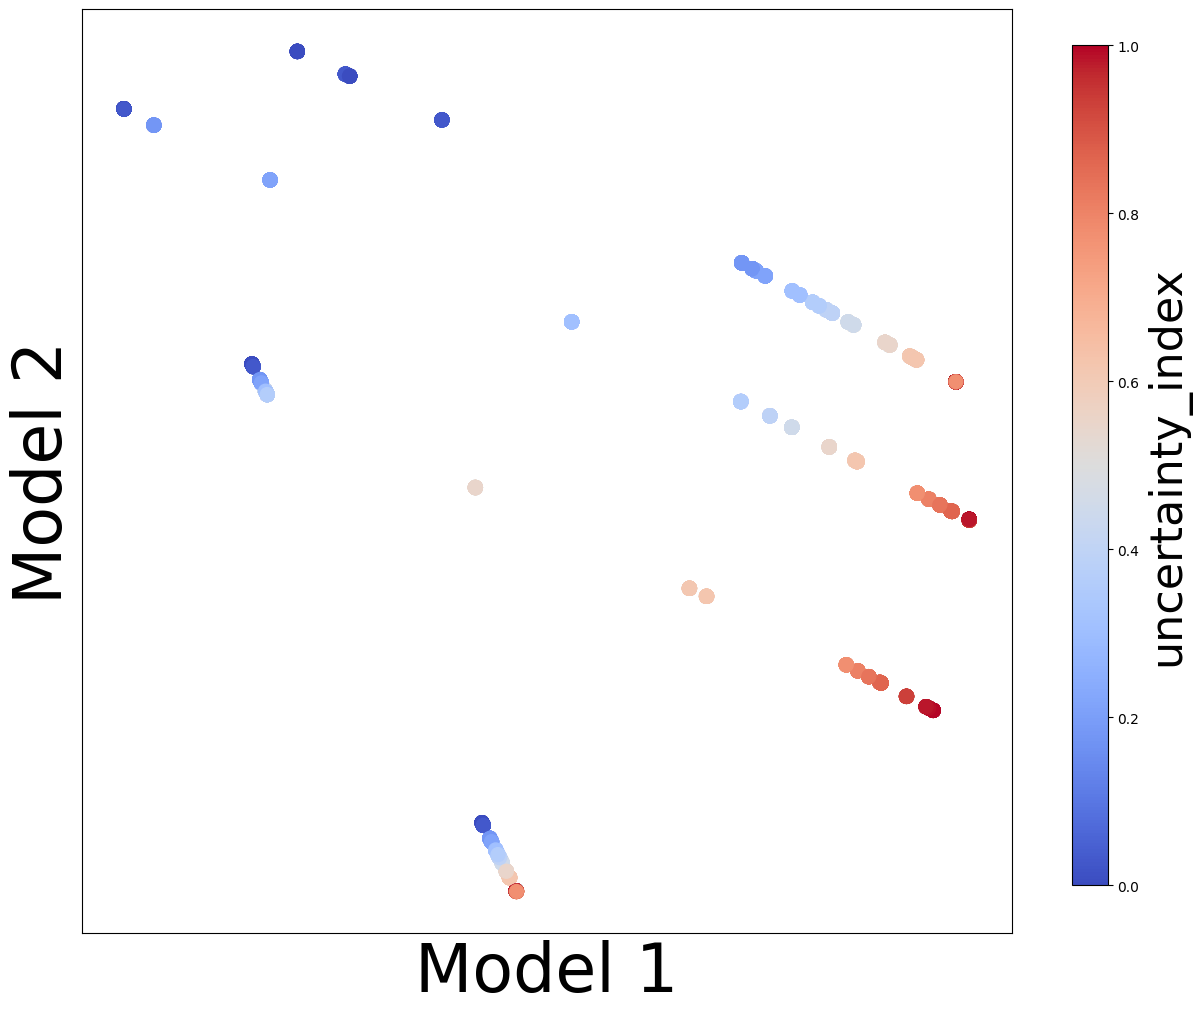

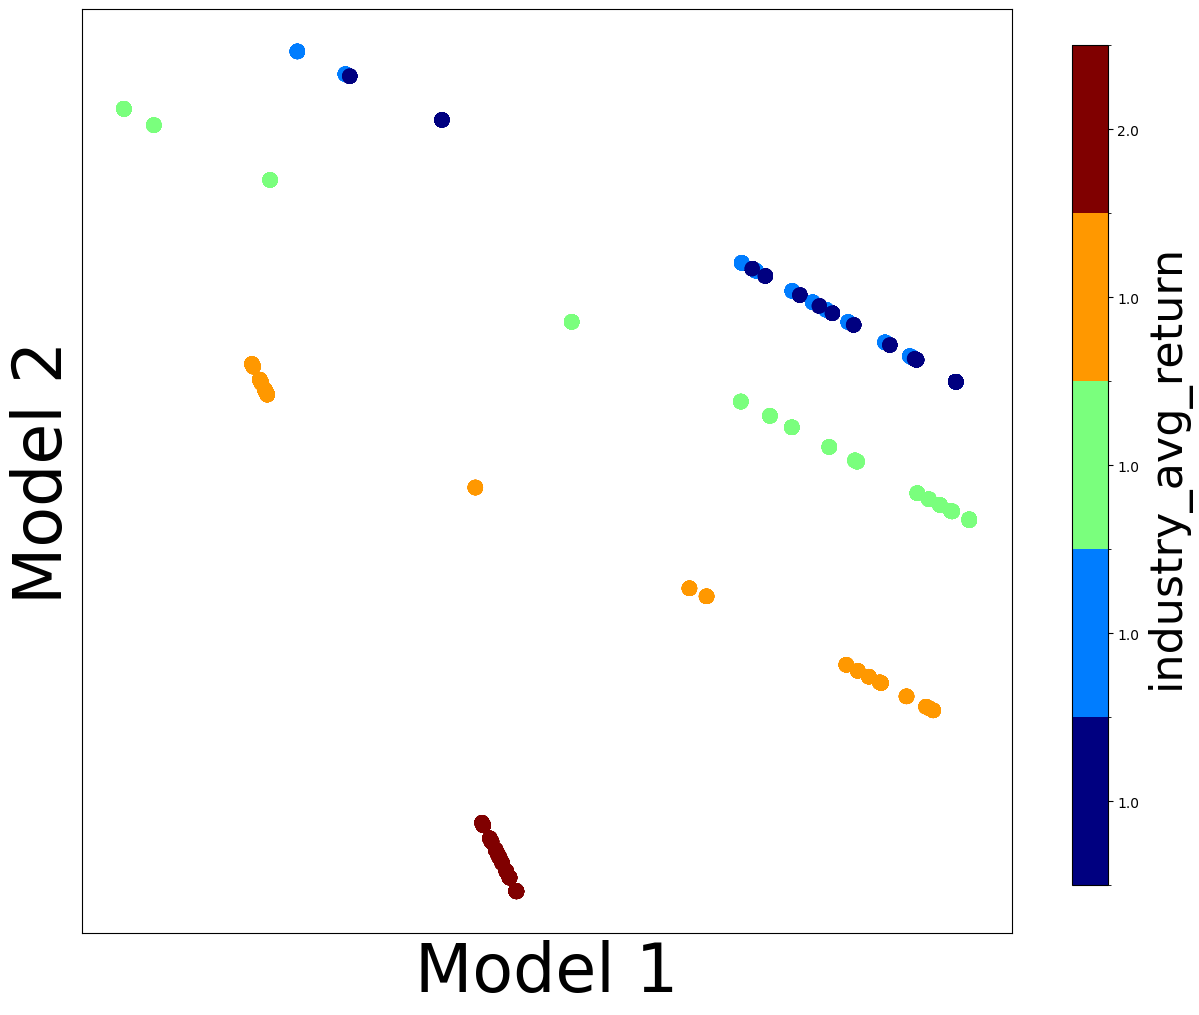

In [ ]:
# A simple helper function is provided in the analysis toolkit for plotting embeddings.
from contextualized.analysis.embeddings import plot_embedding_for_all_covars
plot_embedding_for_all_covars(model_reps, C, xlabel='Model 1', ylabel='Model 2')

In [ ]:
from contextualized.analysis.effects import (
    plot_homogeneous_context_effects,
    plot_homogeneous_predictor_effects,
    plot_heterogeneous_predictor_effects,
)

from contextualized.analysis.pvals import (
    calc_homogeneous_context_effects_pvals,
    calc_homogeneous_predictor_effects_pvals,
    calc_heterogeneous_predictor_effects_pvals
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


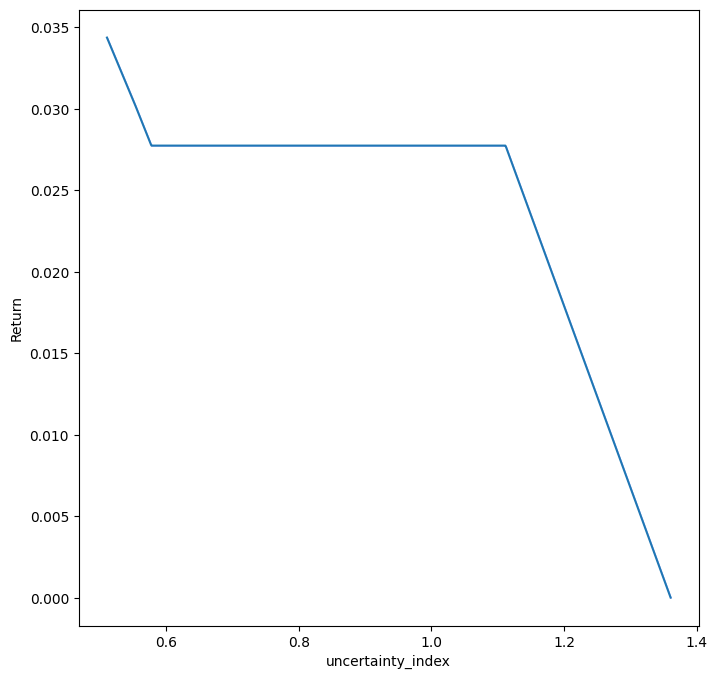

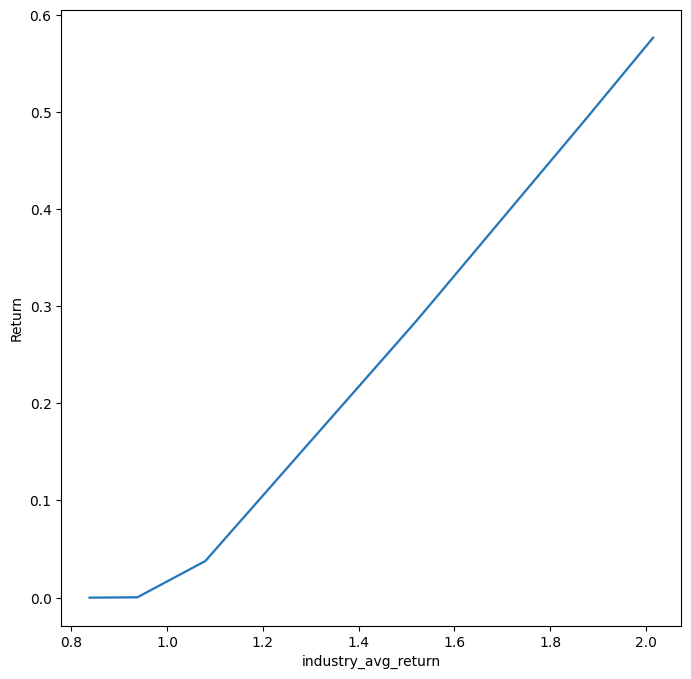

In [ ]:
plot_homogeneous_context_effects(
    model, C, classification=False,
    ylabel="Return", verbose=False)

In [ ]:
%%capture
# We can quantify the uncertainty visualized in the bootstrap confidence intervals
# by measuring p-values of the consistency of the estimated sign of each effect.
homogeneous_context_pvals = calc_homogeneous_context_effects_pvals(model, C)
context_pvals = pd.DataFrame(np.array([
   [C.columns[i], pval[0]] for i, pval in enumerate(homogeneous_context_pvals)
]), columns=["Context Variable", "p-value"])

ValueError: P-values are not well defined without multiple bootstrap samples.

In [ ]:
context_pvals
# Notice that the p-values are calculated from bootstrap resampling,
# so they are limited by the number of bootstraps used.
# Caution: using more bootstraps could artificially inflate confidence.

,Context Variable,p-value
0,stock_bias,0.16666666666666666
1,time_bias,0.16666666666666666
2,uncertainty_index,0.5
3,industry_avg_return,0.5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


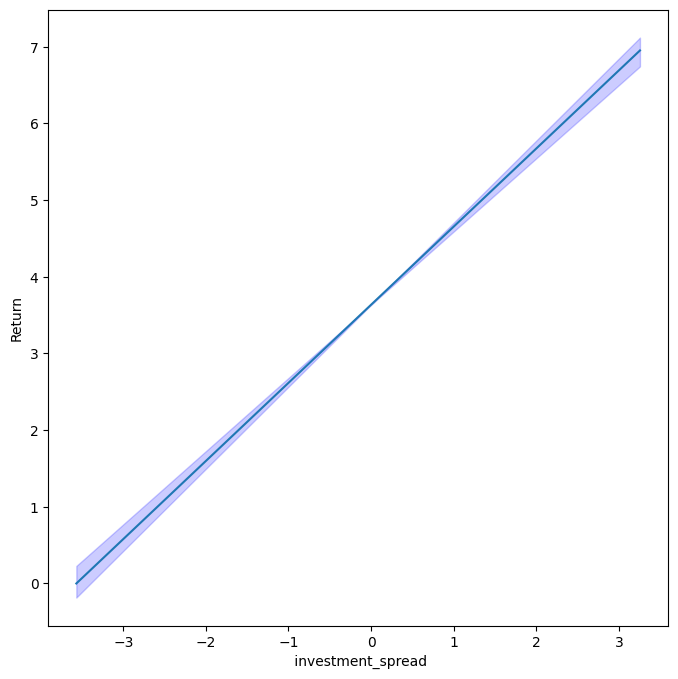

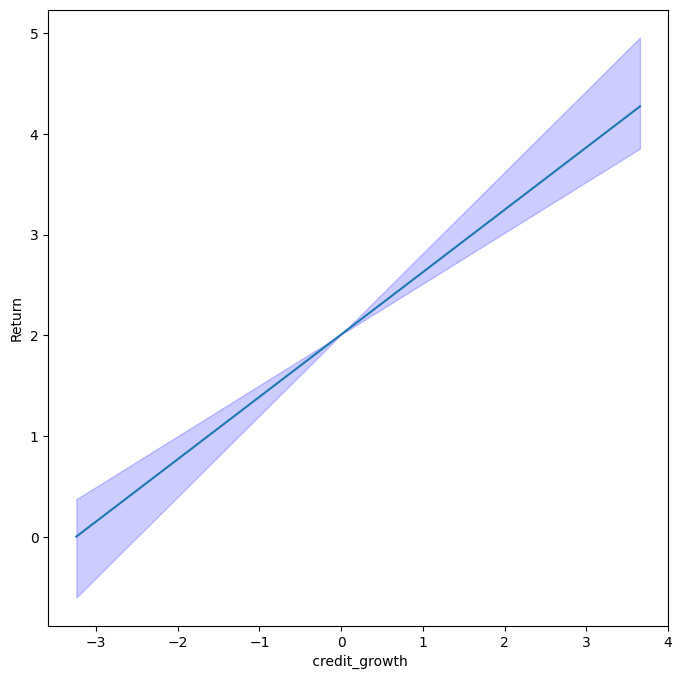

In [ ]:
plot_homogeneous_predictor_effects(
    model, C, X,
    ylabel="Return",
    classification=False)

In [ ]:
%%capture
# We can quantify the uncertainty visualized in the bootstrap confidence intervals
# by measuring p-values of the consistency of the estimated sign of each effect.
homogeneous_predictor_pvals = calc_homogeneous_predictor_effects_pvals(model, C)
predictor_pvals = pd.DataFrame(np.array([
   [X.columns[i], pval[0]] for i, pval in enumerate(homogeneous_predictor_pvals)
]), columns=["Predictor", "p-value"])

In [ ]:
predictor_pvals

,Predictor,p-value
0,investment_spread,0.16666666666666666
1,credit_growth,0.16666666666666666


Generating datapoints for visualization by assuming the encoder is
            an additive model and thus doesn't require sampling on a manifold.
            If the encoder has interactions, please supply C_vis so that we
            can visualize these effects on the correct data manifold.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


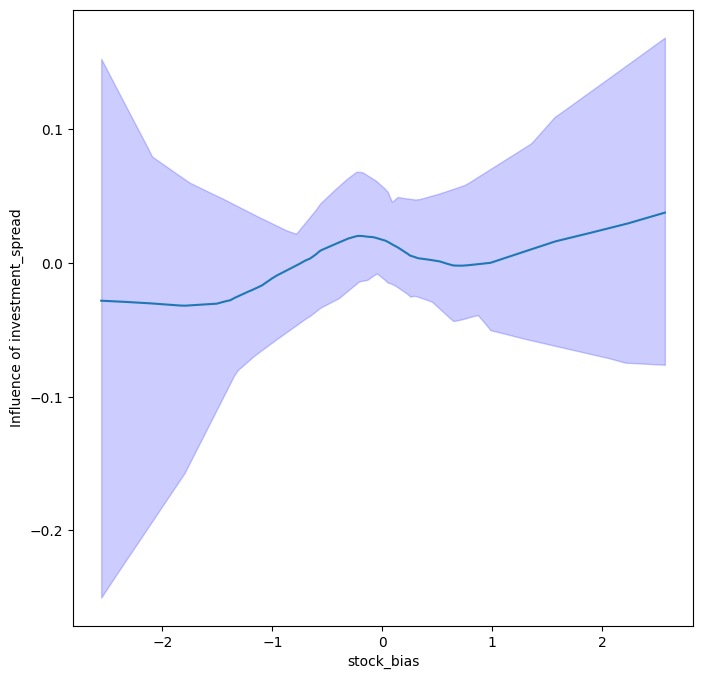

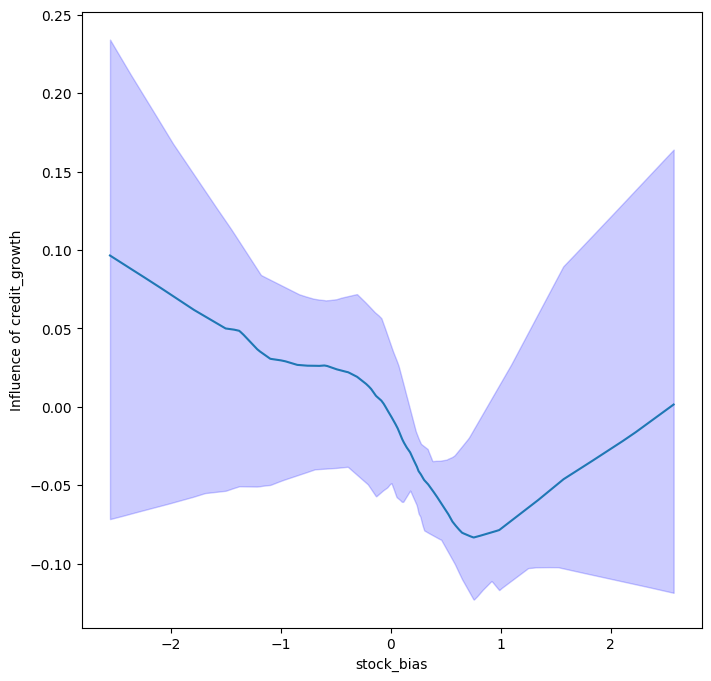

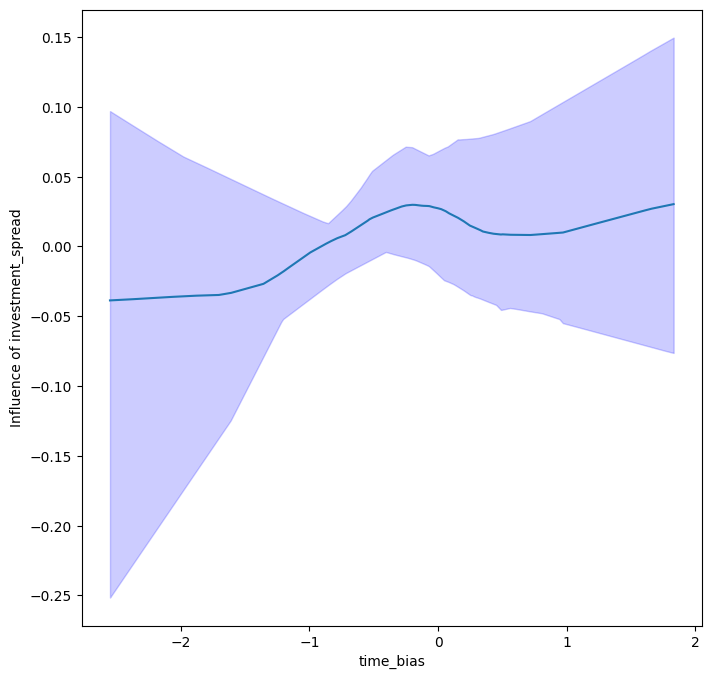

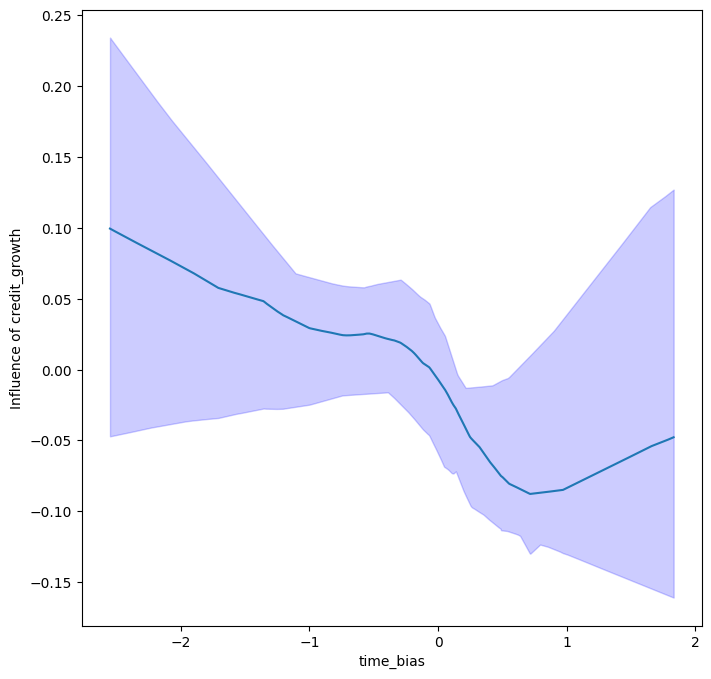

In [ ]:
plot_heterogeneous_predictor_effects(model, C, X, min_effect_size=0.1,
                  ylabel="Influence of")
# Since there are a combinatorial number of heterogeneous predictor effects,
# min_effect_size is a useful parameter to restrict the plotting to
# only the strongest effects.

In [ ]:
%%capture
# We can quantify the uncertainty visualized in the bootstrap confidence intervals
# by measuring p-values of the consistency of the estimated sign of each effect.
# This is a combinatorial: context x predictor
heterogeneous_predictor_pvals = calc_heterogeneous_predictor_effects_pvals(model, C)
predictor_pvals = pd.DataFrame(np.array([
   [C.columns[i // len(X.columns)], X.columns[i % len(X.columns)], pval] for i, pval in enumerate(heterogeneous_predictor_pvals.flatten())
]), columns=["Context", "Predictor", "p-value"])

In [ ]:
predictor_pvals

,Context,Predictor,p-value
0,stock_bias,investment_spread,0.6666666666666666
1,stock_bias,credit_growth,0.3333333333333333
2,time_bias,investment_spread,0.6666666666666666
3,time_bias,credit_growth,0.3333333333333333
4,uncertainty_index,investment_spread,0.3333333333333333
5,uncertainty_index,credit_growth,0.3333333333333333
6,industry_avg_return,investment_spread,0.5
7,industry_avg_return,credit_growth,0.5
